In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Data PreProcessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]


# For double checking
df.to_csv('For_my_use_1.csv', index=False)

print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")

Rows with more than half NaN dropped. Remaining rows: 2811
Rows with more than half NaN dropped. Remaining rows: 2805


In [3]:
chin_variables = [col for col in df.columns if '친' in col and '친단\u3000손' not in col and '친단\u3000자' not in col]
son_variables = [col for col in df.columns if '손' in col]
ja_variables = [col for col in df.columns if '자' in col and '자동차' not in col and '부자재' not in col]

df['chin_total'] = df[chin_variables].sum(axis=1)
df['son_total'] = df[son_variables].sum(axis=1)
df['ja_total'] = df[ja_variables].sum(axis=1)

if 'chin_total' in df.columns:
    target_value = len(df)
    df = df[df['chin_total'] <= 40000]
    removed_target_value = target_value - len(df)
    print(f"Removed {removed_target_value} rows where 'chin_total' > 40000.")
else:
    print(f"Warning: '장입량t' column not found.")

if '수율' in df.columns:
    target_value = len(df)
    df = df[df['수율'] >= 50]
    df = df[df['수율'] <= 110]
    removed_target_value = target_value - len(df)
    print(f"Removed {removed_target_value} rows where 'chin_total' < 50.")
else:
    print(f"Warning: '장입량t' column not found.")

Removed 1 rows where 'chin_total' > 40000.
Removed 11 rows where 'chin_total' < 50.


In [4]:
target = '수율'

# 1. Get all columns except target
variables = ['O2사용량_합계']

# 3. Keep only numeric columns from your cleaned variable list
variables = [v for v in variables if pd.api.types.is_numeric_dtype(df[v])]

# 4. Create X and y
X = df[variables].copy()
y = df[target]

# 5. Replace inf and -inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 6. Drop columns with any NaNs
X = X.dropna(axis=1)

# 7. Train-test split
split_index = int(len(X) * 0.7)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [5]:
# --- Model training and evaluation functions ---

def evaluate_model(name, model, X_train, y_train, X_test, y_test, df):
    print(f"\n--- {name} Model Evaluation ---")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # --- Calculate Metrics ---
    # Train
    mse_train = mean_squared_error(y_train, train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, train_pred)
    mape_train = np.mean(np.abs((y_train - train_pred) / y_train)) * 100
    r2_train = r2_score(y_train, train_pred)

    # Test
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, test_pred)
    mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
    r2_test = r2_score(y_test, test_pred)

    # --- Print Metrics ---
    print(f"{name} Train Scores:")
    print(f"  MSE:  {mse_train:.2f}")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  MAPE: {mape_train:.2f}%")
    print(f"  R²:   {r2_train:.3f}")

    print(f"\n{name} Test Scores:")
    print(f"  MSE:  {mse_test:.2f}")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  MAPE: {mape_test:.2f}%")
    print(f"  R²:   {r2_test:.3f}")
    
    # Plot
    train_df = df[['강번']].loc[X_train.index].copy()
    train_df['Actual'] = y_train.values
    train_df['Predicted'] = train_pred
    train_df['Set'] = 'Train'

    test_df = df[['강번']].loc[X_test.index].copy()
    test_df['Actual'] = y_test.values
    test_df['Predicted'] = test_pred
    test_df['Set'] = 'Test'

    combined_df = pd.concat([train_df, test_df]).sort_values('강번').reset_index(drop=True)
    combined_df['Time Index'] = range(len(combined_df))

    plt.figure(figsize=(16, 4))
    plt.plot(combined_df['Time Index'], combined_df['Actual'], label='Actual', linewidth=2)
    plt.plot(combined_df['Time Index'], combined_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    test_start = combined_df[combined_df['Set'] == 'Test']['Time Index'].min()
    plt.axvline(x=test_start, color='red', linestyle=':', label='Test Start')
    plt.xlabel('Time Index (chronological)', fontsize=14)
    plt.ylabel(target, fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', labelsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test-only plot
    test_df = test_df.sort_values('강번').reset_index(drop=True)
    test_df['Time Index'] = range(len(test_df))

    plt.figure(figsize=(18, 3))
    plt.plot(test_df['Time Index'], test_df['Actual'], label='Actual', linewidth=2)
    plt.plot(test_df['Time Index'], test_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    plt.xlabel('Time Index (chronological)', fontsize=14)
    plt.ylabel(target, fontsize=14)
    plt.title(f'Actual vs Predicted {target} ({name}) - R² = {r2_test:.3f}, RMSE = {rmse_test:.1f}', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', labelsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# MLR


--- Linear Regression Model Evaluation ---
Linear Regression Train Scores:
  MSE:  3.47
  RMSE: 1.86
  MAE:  1.42
  MAPE: 1.53%
  R²:   0.000

Linear Regression Test Scores:
  MSE:  3.44
  RMSE: 1.85
  MAE:  1.37
  MAPE: 1.49%
  R²:   -0.070


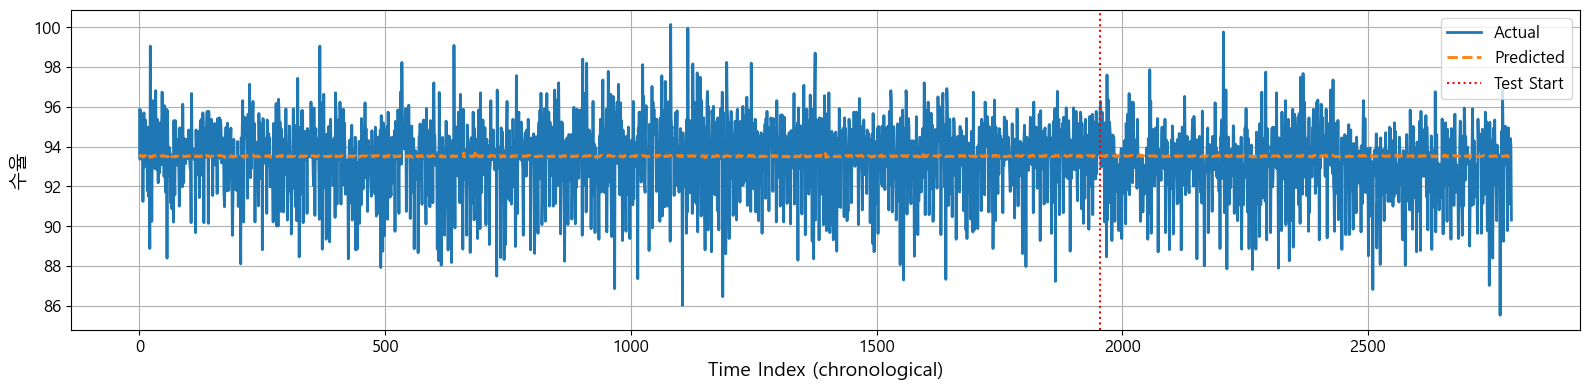

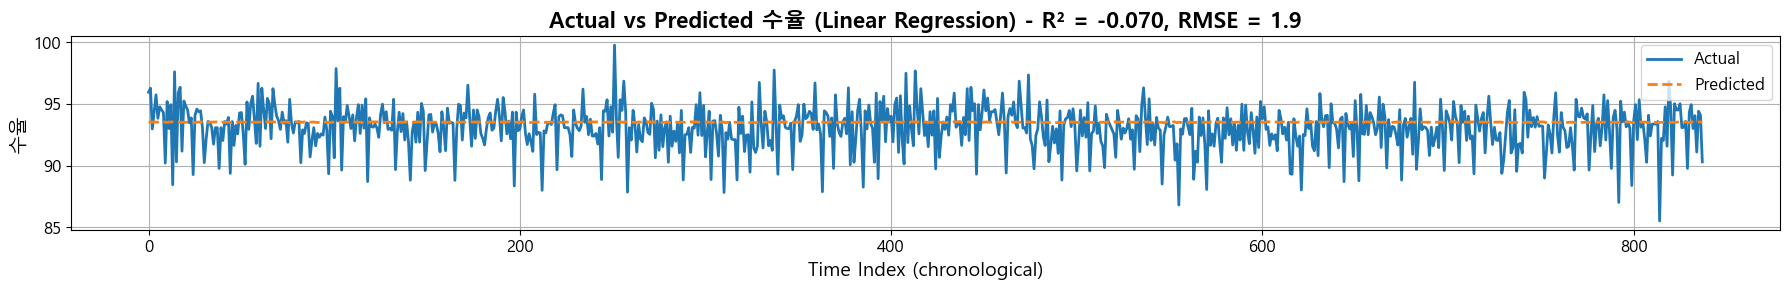

In [6]:
# --- Linear Regression ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
evaluate_model("Linear Regression", lin_model, X_train, y_train, X_test, y_test, df)

# XGBoost


--- XGBoost Model Evaluation ---
XGBoost Train Scores:
  MSE:  3.28
  RMSE: 1.81
  MAE:  1.38
  MAPE: 1.48%
  R²:   0.055

XGBoost Test Scores:
  MSE:  3.47
  RMSE: 1.86
  MAE:  1.39
  MAPE: 1.51%
  R²:   -0.079


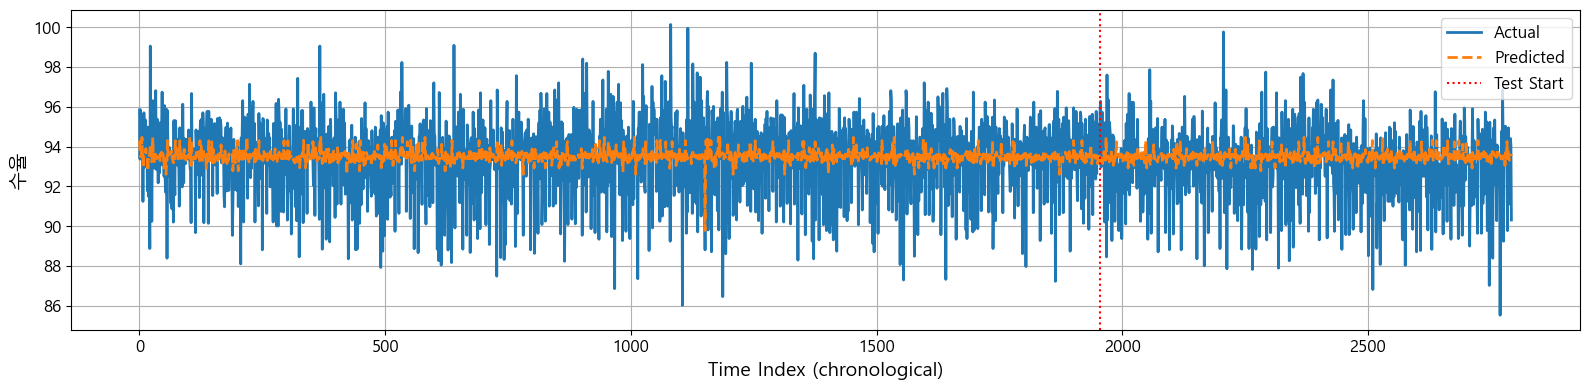

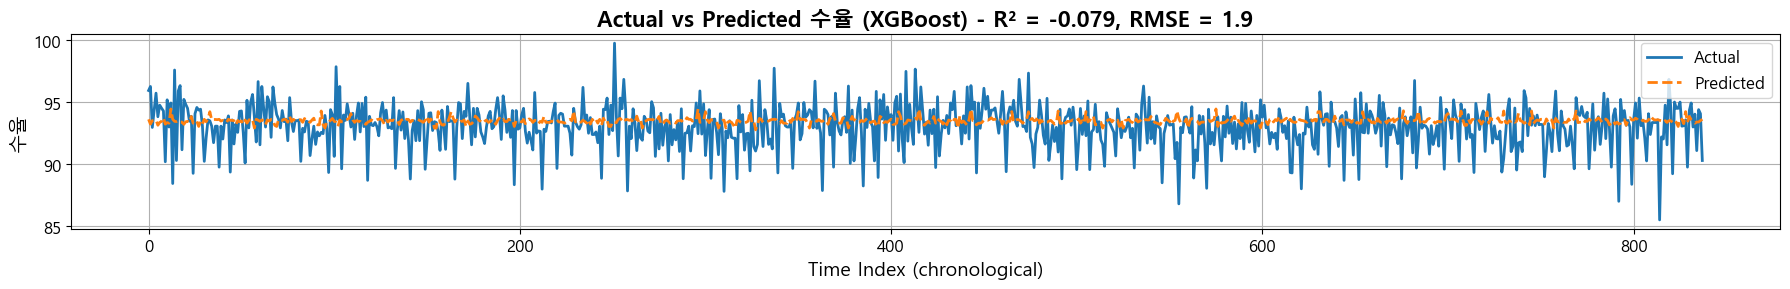

In [7]:
# --- XGBoost ---
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test, df)

# RandomForest


--- Random Forest Model Evaluation ---
Random Forest Train Scores:
  MSE:  2.94
  RMSE: 1.72
  MAE:  1.31
  MAPE: 1.41%
  R²:   0.151

Random Forest Test Scores:
  MSE:  3.79
  RMSE: 1.95
  MAE:  1.48
  MAPE: 1.61%
  R²:   -0.181


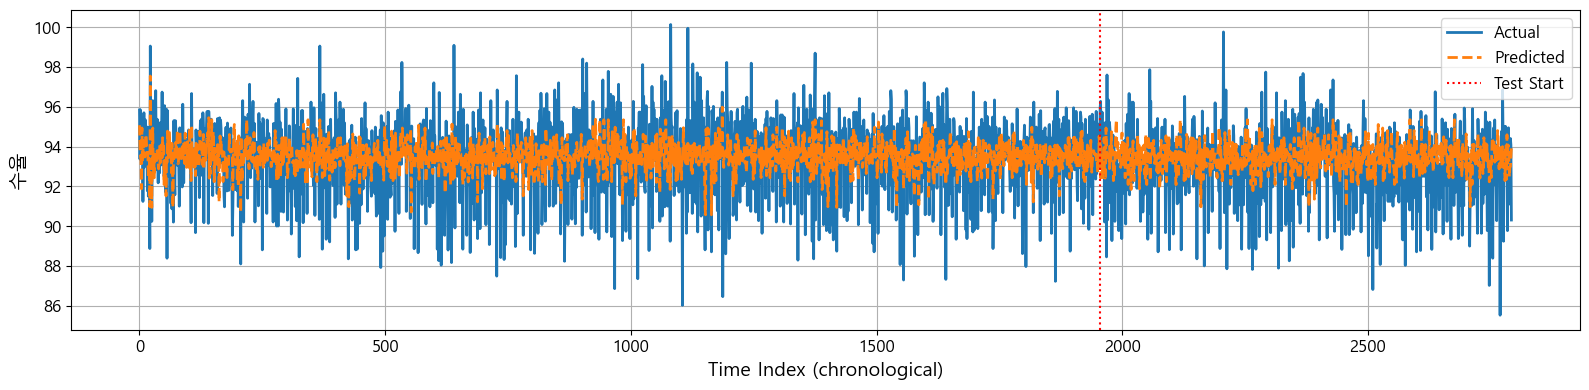

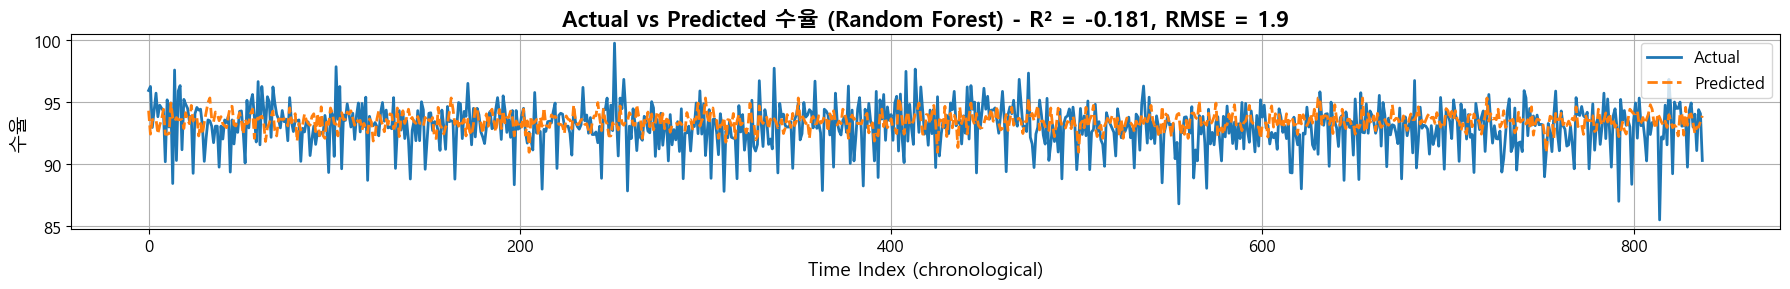

In [8]:
# --- Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test, df)

# SHAP


--- SHAP Summary: Linear Regression ---


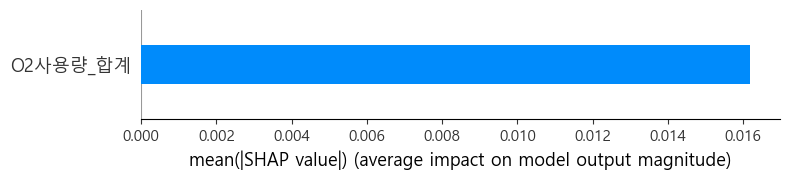

In [9]:
# SHAP for linear model
explainer_lin = shap.Explainer(lin_model, X_train)
shap_values_lin = explainer_lin(X_train)

# Global importance plot
print("\n--- SHAP Summary: Linear Regression ---")
shap.summary_plot(shap_values_lin, X_train, plot_type="bar")

 96%|=================== | 1879/1955 [00:23<00:00]       


--- SHAP Summary: XGBoost ---


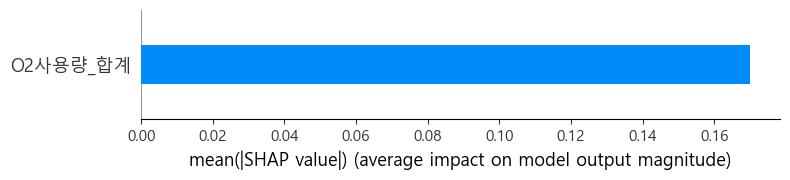

In [10]:
# SHAP for XGBoost (TreeExplainer is fast and accurate)
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_train)

# Global importance plot
print("\n--- SHAP Summary: XGBoost ---")
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")

 92%|==================  | 1807/1955 [00:11<00:00]       


--- SHAP Summary: Random Forest ---


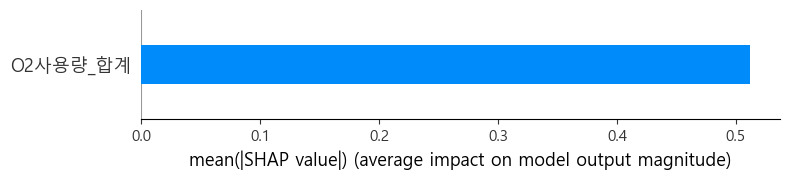

In [11]:
# SHAP for Random Forest
explainer_rf = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer_rf(X_train)

# Global importance plot
print("\n--- SHAP Summary: Random Forest ---")
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")